In [4]:
# 한국어 적용과 시각화설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

import pandas as pd
import tensorflow as tf


print(pd.__version__)
print(tf.__version__)
print(mpl.__version__)

print("완료!")

1.3.3
2.6.0
3.4.3
완료!


# 데이터 준비
프로젝트 라이브러리

In [8]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
import tarfile

print(tf.__version__)

2.6.0


# 데이터 전처리 
## 1. 정제
set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

In [14]:
# 파일 다운로드 및 압축 해제
path_to_tar = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=False)

# 파일 압축 해제
tar = tarfile.open(path_to_tar)
tar.extractall(path=os.path.dirname(path_to_tar))
tar.close()

# 파일 경로 설정
path_to_ko = os.path.join(os.path.dirname(path_to_tar), "korean-english-park.train.ko")
path_to_en = os.path.join(os.path.dirname(path_to_tar), "korean-english-park.train.en")


In [11]:
from konlpy.tag import Mecab


# 파일 내용 읽기
with open(path_to_ko, 'r', encoding='utf-8') as f:
    kor_data = f.read().splitlines()

with open(path_to_en, 'r', encoding='utf-8') as f:
    eng_data = f.read().splitlines()

# 데이터 크기와 예시 출력
print("한국어 데이터 크기:", len(kor_data))
print("영어 데이터 크기:", len(eng_data))
print("한국어 예시 데이터:")
for sen in kor_data[:10]:
    print(">>", sen)

print("영어 예시 데이터:")
for sen in eng_data[:10]:
    print(">>", sen)

# 중복 데이터 제거
cleaned_corpus = list(set(zip(kor_data, eng_data)))


# 길이가 40 이하인 데이터 필터링
def filter_long_sentences(kor, eng, max_len=40):
    filtered_kor = []
    filtered_eng = []
    
    for k, e in zip(kor, eng):
        if len(k.split()) <= max_len and len(e.split()) <= max_len:
            filtered_kor.append(k)
            filtered_eng.append(e)
    
    return filtered_kor, filtered_eng

filtered_kor, filtered_eng = filter_long_sentences(kor_data, eng_data)

cleaned_corpus = list(set(zip(filtered_kor, filtered_eng)))

# 전처리 함수 정의
mecab = Mecab()

def preprocess_sentence_korean(sentence, s_token=False, e_token=False):
    sentence = sentence.strip()
    
    # 특수 문자 제거
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한글과 영어를 제외한 문자 제거
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

# 병렬 데이터 전처리
kor_corpus = []
eng_corpus = []

for kor, eng in cleaned_corpus:
    kor_corpus.append(preprocess_sentence_korean(kor))
    eng_corpus.append(preprocess_sentence_korean(eng, s_token=True, e_token=True))

print("전처리 후 한국어 예시 데이터:", kor_corpus[:5])
print("전처리 후 영어 예시 데이터:", eng_corpus[:5])





print("필터링 후 한국어 데이터 크기:", len(kor_corpus))
print("필터링 후 영어 데이터 크기:", len(eng_corpus))


한국어 데이터 크기: 94123
영어 데이터 크기: 94123
한국어 예시 데이터:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
>> 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
>> 국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
>> 이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
>> "결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
>> 연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.
영어 예시 데이터:
>> Much of personal computing is about "can you top this?"
>> so a mentio

## 2. 토큰화
### 앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

In [13]:
# 토큰화 함수
def tokenize(corpus, is_korean=False, num_words=10000):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)
    if is_korean:
        corpus = [' '.join(mecab.morphs(sentence)) for sentence in corpus]
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
# 한국어와 영어 문장을 각각 토큰화
enc_tensor, enc_tokenizer = tokenize(kor_corpus, is_korean=True)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

# 데이터셋의 크기 출력
print("훈련 데이터의 크기:", len(enc_tensor), len(dec_tensor))

훈련 데이터의 크기: 75577 75577


# 모델설계
### Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고, Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만들어 냅니다.Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다.여기서 't=1 일 때의 Hidden State는 어떻게 정의할 것인가?' 가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.

In [35]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


In [40]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [41]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [42]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 256
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 256)
Decoder Output: (64, 43162)
Decoder Hidden State: (64, 256)
Attention: (64, 30, 1)


# Optimizer & Loss

In [43]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


### Optimizer는 모델이 학습할 때에 정답을 찾아가는 방법

### fit() 함수를 사용할 수 없는 이유는 바로 Loss 함수 때문

### Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용

SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구해줍니다. CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점하는 거죠. from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정합니다. 우리는 True 로 줬으니 모델의 출력값을 그대로 전달하면 됩니다!

### 패딩에 대한 처리를 해주지 않으면 "PAD" 토큰만을 생성할 확률이 굉장히 높아집니다.

mask 는 정답지에서 'PAD' 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 해주죠. equal() 함수에 정확히는 0 이 아닌 <PAD> 토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리

# 훈련

train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수

In [44]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


@tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다.

tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프입니다. 이것은 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용

1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성

2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
3. Decoder에 입력으로 전달할 'start' 토큰 문장 생성
4. 'start' 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
6. 반복!

In [45]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm


Epoch  5: 100%|██████████| 1181/1181 [04:51<00:00,  4.05it/s, Loss 2.6741]


In [64]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence_korean(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


In [65]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


Input: Can I have some coffee ?
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_31/3667068388.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/3667068388.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


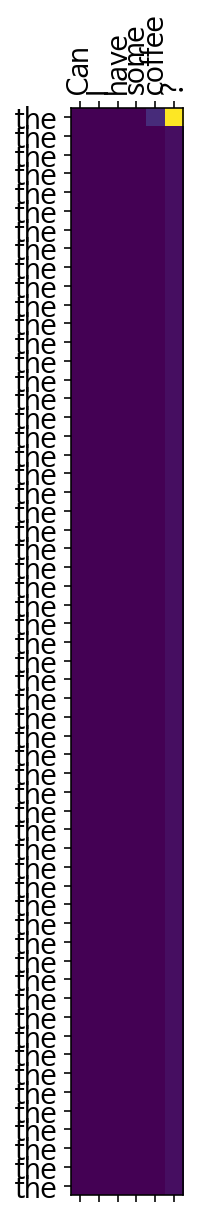

In [66]:
translate("Can I have some coffee?", encoder, decoder)

Input: 오바마는 대통령이다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_31/3667068388.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_31/3667068388.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


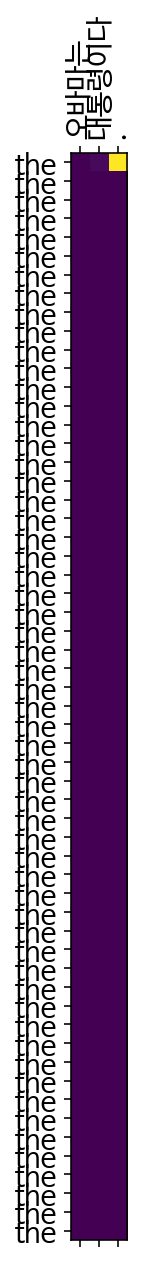

Input: 시민들은 도시 속에 산다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


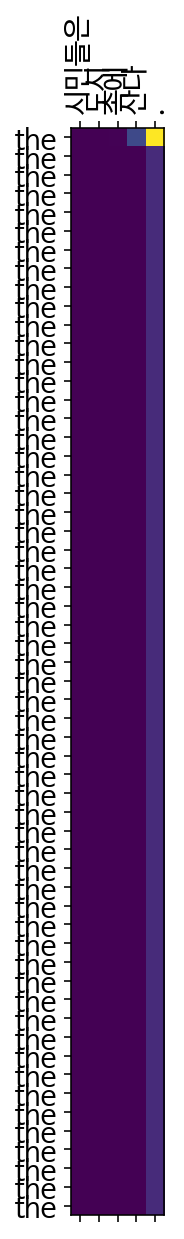

Input: 커피는 필요 없다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


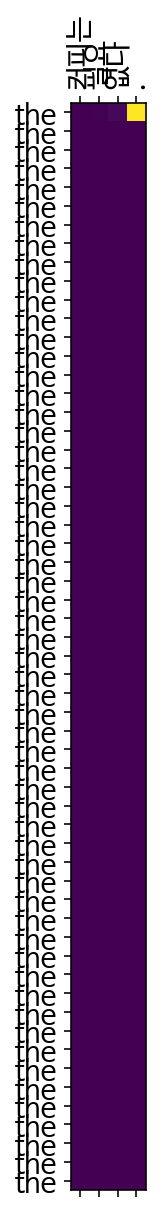

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


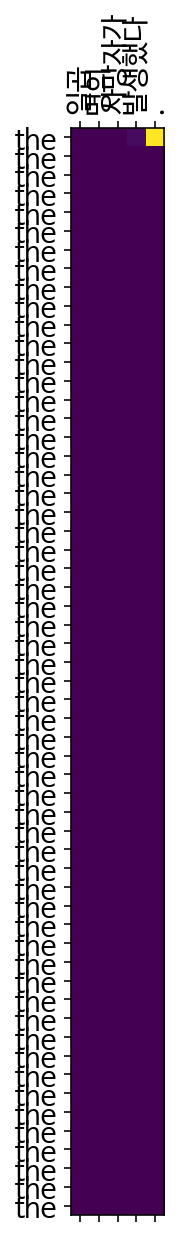

In [67]:
# 주어진 예문
sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

for sentence in sentences:
    translate(sentence, encoder, decoder)